# Classification with Dirichlet prior

In [1]:
%load_ext autoreload
%autoreload 2
import site
import time
site.addsitedir('..')

import jax
from jax.config import config
import jax.numpy as jnp
import numpy as np
from  matplotlib import pyplot as plt
from tqdm import tqdm

from jax.scipy.special import gammaln
from jax import random

from src.algorithm import mcmc

plt.rcParams["figure.figsize"]=6,6
#config.update("jax_enable_x64", True)

### Setup

The probability vector $\pi$ is drawn from a Dirichlet distribution with parameter $\alpha$.

$\pi \sim \text{Dirichlet}(\alpha)$

The $K$ classes $x_1, \ldots, x_K$ are i.i.d. samples from a standard normal distribution and we have $N$ noisy observations $y_1, \ldots, y_N$ of the $K$ classes such that:

$y_i = x_{z_i} + \sigma \eta_i,$

where $\eta_i \sim \mathcal{N}(0,1)$ and $z_1, \ldots, z_N$ are drawn from a multinomial distribution with
probability vector $\pi$.

In [41]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, *subkeys = random.split(key, 5)

In [42]:
K = 3
N = 1000
sigma = 0.01
alpha = 0.7 * jnp.ones(K,)
#alpha = jnp.array([10,10,2])

In [43]:
pi = random.dirichlet(subkeys[0], alpha)
z = random.categorical(subkeys[1], jnp.log(pi), shape = (N,))
print(f"pi = {pi}")

pi = [0.02563246 0.9466571  0.0277105 ]


x = [1.4466679  0.82188    0.35398227]


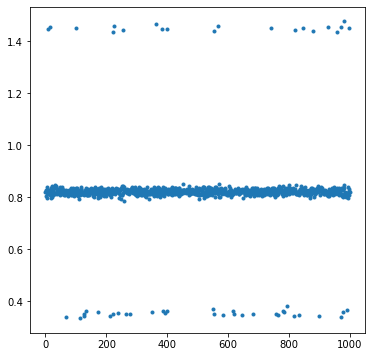

In [44]:
x = random.normal(subkeys[2], shape = (K,))
y = x[z] + sigma * random.normal(subkeys[3], shape = (N,))

print(f"x = {x}")
_ = plt.plot(y, '.')

### The posterior and proposal functions

In [56]:
# This log posterior marginalizes over the classes k = 1,...,K.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    #logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) *  (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
        
        #logPZalpha += gammaln(n_k[k] + alpha[k])
      
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) 
   
# And this does not.
def logPi(x, z, y, sigma, alpha):
    #n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    #Nk = jnp.sum(n_k)
    #Ak = jnp.sum(alpha)
    
    #n_ik_z = jax.vmap(lambda i : n_ik[i, z[i]])(jnp.arange(N))
    
    term1 = jnp.sum(-(y - x[z])**2/sigma)
    #term2 = jnp.sum(jnp.log(n_ik_z + alpha[z])) 

    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

    #return term1 + term2 - jnp.sum(x**2) #+ logPZalpha 
    return term1 - jnp.sum(x**2) #+ logPZalpha 


def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [57]:
print(logPi_marg(x, z, y, sigma, alpha))
print(logPi_marg(xi, zi, y, sigma, alpha))

-256.8144
-257.44403


In [59]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

-12.429692
-13.059307


In [61]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_k] from the posterior
    
    p(x_1, ..., x_K | y_1, ..., y_N)
    
    with marginalization over z_1,...z_N."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_K] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    without marginalization over z_i variales (where we keep z_i fixed)."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x_idx(key, x0, logPiX0, B, z, y, sigma, alpha, idx):
    """Proposal function for a new state x_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)
    
    where all z_i and the other x_j are fixed and with no
    marginalization over z.

    The returned vector x1 is equal to x0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.uniform(key) * 2*B-B
    x1 = x0.at[idx].set(newval)
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x1, r, logPiX1, logPiX0    
               
@jax.jit
def proposal_x_batch(key, x0, logPiX0, B, z, y, sigma, alpha):
    keys = random.split(key, K)
    
    x1, r, logPiX1, logPiX0 = jax.vmap(proposal_x_idx, in_axes = (0, None, None, None, None, None, None, None, 0))(keys, x0, logPiX0, B, z, y, sigma, alpha, jnp.arange(K))
    x1 = jnp.diag(x1)
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Proposal function of a new vector [z_1,...,z_N] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where the x_i variables are fixed."""
    
    z1 = random.randint(key, z0.shape, 0, K) 

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_idx(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    """Proposal function of a new state z_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all x_i and the other z_j are fixed.
    
    The returned vector z1 is equal to z0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_batch(key, z0, logPiX0, x, y, sigma, alpha, K):
    keys = random.split(key, N)
    
    # TODO: change both batch functions so we don't have to do diag on an N x N (or K x K) matrix
    z1, r, logPiX1, logPiX0 = jax.vmap(proposal_z_idx, in_axes = (0, None, None, None, None, None, None, None, 0))(keys, z0, logPiX0, x, y, sigma, alpha, K, jnp.arange(N))
    z1 = jnp.diag(z1)
    
    return z1, r, logPiX1, logPiX0
    


### Sample x

In [9]:
print(f"pi = {pi}")
print(f"x = {x}")

pi = [0.10677198 0.0045143  0.8887137 ]
x = [ 1.1151052  -0.93441594 -1.1421528 ]


In [309]:
#z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
#z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

  MCMC sample 1000, loss = -1335.57177734375, a = 0.0
  MCMC sample 2000, loss = -1231.68701171875, a = 0.0
  MCMC sample 3000, loss = -1029.581787109375, a = 0.0
  MCMC sample 4000, loss = -1029.581787109375, a = 0.0
  MCMC sample 5000, loss = -1029.581787109375, a = 0.0
  MCMC sample 6000, loss = -1029.581787109375, a = 0.0
  MCMC sample 7000, loss = -1029.581787109375, a = 0.0
  MCMC sample 8000, loss = -1029.581787109375, a = 0.0
  MCMC sample 9000, loss = -1029.581787109375, a = 0.0
18.01808214187622 sec
x_samp = [ 0.85332584  0.88558745 -0.7734983 ]
x_true = [ 0.8836729   0.64198554 -0.8476923 ]


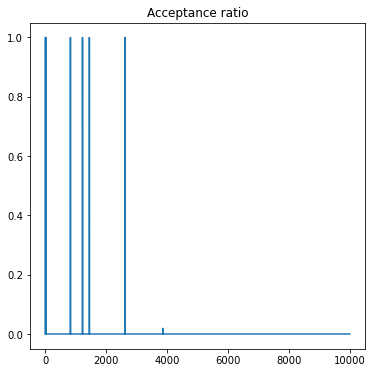

In [310]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### And the non-marginalized posterior

  MCMC sample 1000 , loss = -34.81849
  MCMC sample 2000 , loss = -35.11338
  MCMC sample 3000 , loss = -34.963554
  MCMC sample 4000 , loss = -33.955776
  MCMC sample 5000 , loss = -34.979713
  MCMC sample 6000 , loss = -34.18979
  MCMC sample 7000 , loss = -34.896736
  MCMC sample 8000 , loss = -34.33084
  MCMC sample 9000 , loss = -34.594704
2.9339189529418945 sec
x_samp = [ 0.8789027   0.64016104 -0.8497381 ]
x_true = [ 0.8836729   0.64198554 -0.8476923 ]


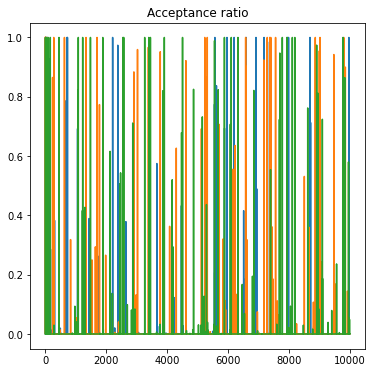

In [321]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_batch, x0, N_samples_x, params_x, K, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

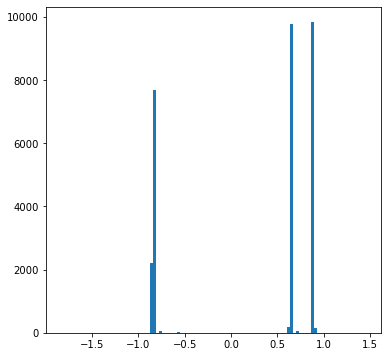

In [324]:
nbins=100
counts, bins = np.histogram(x_samples[:,:], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

#### One $x_i$ at a time

  MCMC sample 1000, loss = -14264.7412109375, a = 0.0
  MCMC sample 2000, loss = -14265.80859375, a = 0.0
  MCMC sample 3000, loss = -14265.287109375, a = 0.0
  MCMC sample 4000, loss = -14264.7353515625, a = 1.3010454140147634e-23
  MCMC sample 5000, loss = -14264.921875, a = 0.0
  MCMC sample 6000, loss = -14265.1005859375, a = 0.0
  MCMC sample 7000, loss = -14265.1435546875, a = 0.0
  MCMC sample 8000, loss = -14264.7333984375, a = 0.0
  MCMC sample 9000, loss = -14264.978515625, a = 0.0
  MCMC sample 10000, loss = -14265.0205078125, a = 0.0
2.8189492225646973 sec
x_samp = [ 1.5001683 -0.2680899 -0.8500142]
x_true = [ 0.8836729   0.64198554 -0.8476923 ]


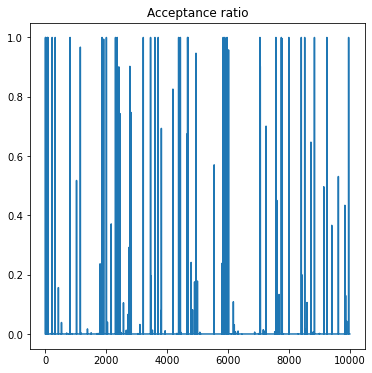

In [320]:
N_samples_x = 10001
B = 3

idx = 2
x0 = jnp.array(np.random.randn(K))

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

In [319]:
x_samples.shape

(9999, 3)

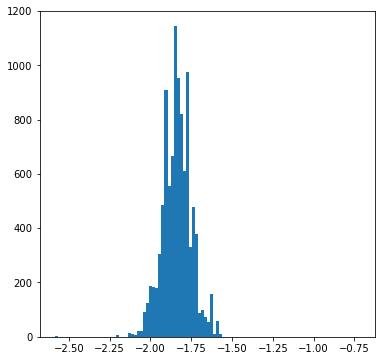

In [236]:
nbins=100
counts, bins = np.histogram(x_samples[:,idx], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

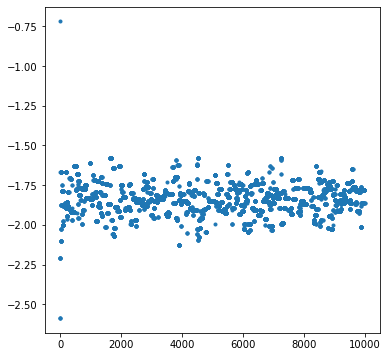

In [237]:
plt.plot(x_samples[:,idx],'.')

### Sample z

In [408]:
N_samples_z = 1000
z0 = jnp.array(np.random.randint(0, K, (N,)))
#z0 = z.at[idx].set(np.random.randint(0,K,()))

B = 2
idx = 10
#params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx}
params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)

t0 = time.time()
#z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, z0, N_samples_z, params_z, 1, 1)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch, z0, N_samples_z, params_z, N, 1)

#z_samples = z_samples[:,idx]

print(f"{time.time()-t0} sec")
#plt.plot(z_r); plt.title("Acceptance ratio")
print(f"z[idx]_samp = {z_samples[N_samples_z-2]}")
print(f"z[idx]_true = {z[idx]}")


3.7437188625335693 sec
z[idx]_samp = [2 0 0 1 1 0 0 0 1 2 1 1 0 0 1 1 2 0 2 0 0 2 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 2 1 1 2 1 2 1 0 1 1 0 1 1 2 1 0 0 2 0 0 0 2 0 2 0 2 1 0 0 1 2 0 0 2
 2 0 0 0 0 1 1 1 2 0 1 2 0 1 0 0 0 0 0 0 0 2 0 0 0 1 2 0 0 2 0 1 0 2 0 1 2
 2 0 1 1 0 2 1 0 0 2 2 0 0 2 0 0 0 2 0 0 1 0 1 2 2 2 2 2 0 2 2 0 2 0 0 1 1
 0 2 1 0 0 1 2 0 0 1 0 0 0 1 0 0 2 1 1 1 1 1 2 1 0 0 0 0 1 1 2 1 0 0 0 0 2
 2 1 0 0 1 2 0 1 2 2 0 2 0 0 2 0 1 0 0 2 0 0 0 2 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 2 0 2 0 0 0 0 0 1 0 0 2 2 2 2 0 2 0 2 2 1 0 0 1 0 0 0 0 0 0 2 2 2 2 0
 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 2 2 0 0 0 2 2 1 1 2 1 0 2 0 1 0
 0 0 0 2 1 0 0 2 0 2 2 1 0 1 2 0 0 1 2 0 0 0 0 1 0 1 0 2 2 1 0 1 0 0 0 0 0
 1 1 2 2 0 0 0 1 0 0 0 0 0 1 2 2 0 0 0 0 1 0 0 0 2 0 1 0 0 0 2 1 1 0 1 0 1
 2 1 2 0 0 0 0 0 0 0 0 0 0 1 1 0 1 2 0 1 1 0 0 0 1 0 1 2 2 1 0 0 0 2 0 0 0
 1 0 0 1 0 0 0 2 0 1 2 2 0 0 2 1 2 0 0 0 2 1 1 0 0 0 0 1 2 1 2 0 0 2 2 0 2
 2 0 0 0 0 1 2 0 2 1 0 2 2 0 0 0 2 0 1 0 0 0 0 0 1 0 0 0 1 0 2 

In [409]:
z_samples.shape

(999, 1000)

In [410]:
print(jnp.sum(jnp.abs(z0-z)))
print(jnp.sum(jnp.abs(z_samples[N_samples_z-2,:]-z)))

939
107


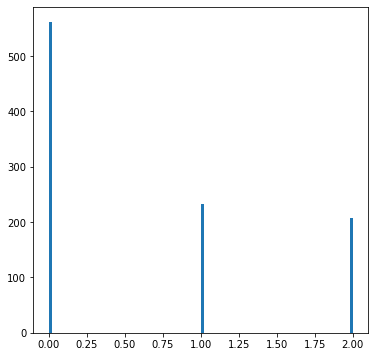

In [411]:
nbins=100
counts, bins = np.histogram(z_samples[N_samples_z-2,:], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [412]:
z_samples.shape

(999, 1000)

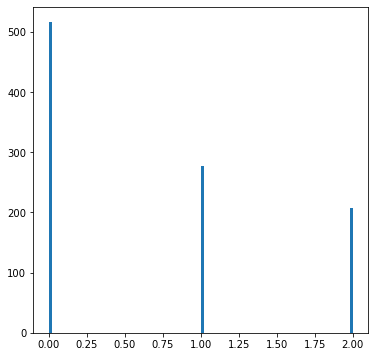

In [413]:
nbins=100
counts, bins = np.histogram(z, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### Sample $x$ and $z$

In [414]:
K

3

In [62]:
N_iters = 10
N_samples_z = 1001 #300
N_samples_x = 10001
B = 3

sample_x = True
sample_z = True
search_z = False

zi = jnp.array(np.random.randint(0, K, (N,)))
xi = jnp.array(np.random.randn(K))

#xi = x
#zi = z

t0 = time.time()
for iter_i in jnp.arange(N_iters):
    print(f"Iter = {iter_i}")

    if sample_x:
        print("  Sampling x")
        #for idx_x in jnp.arange(K):

        #params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx_x}
        params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha}

        key, subkey = random.split(key)
    
        #t0 = time.time()
        x_mean, x_r, x_samples = mcmc(subkey, proposal_x_batch, xi, N_samples_x, params_x, K, 1) 
        #x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, xi, N_samples_x, params_x, 1, 1) 

        xi = x_samples[N_samples_x - 2]
    
    if search_z:
        print("  Searching z")
        for idx_z in tqdm(jnp.arange(N)):
            logPi_max = -jnp.inf

            for ki in jnp.arange(K):
                zi_k = zi.at[idx_z].set(ki)
                logPi_k = logPi(xi, zi_k, y, sigma, alpha)
                if logPi_k > logPi_max:
                    zi = zi_k
                    logPi_max = logPi_k
            
    if sample_z:
        print("  Sampling z")
        #for idx_z in tqdm(jnp.arange(N)):
            
        #params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx_z}
        params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

        key, subkey = random.split(key)

        #z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, zi, N_samples_z, params_z, 1, 1)
        z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch, zi, N_samples_z, params_z, N, 1)

        zi = z_samples[N_samples_z - 2]
            
            #new_zi = jnp.bincount(z_samples[:,idx_z]).argmax()
            #zi = zi.at[idx_z].set(new_zi)
            
            #if zi[idx_z] - z[idx_z] != 0:
            #    break
            

print(f"{time.time()-t0} sec")
print(f"x_samp = {xi}")
print(f"x_true = {x}")

Iter = 0
  Sampling x
  MCMC sample 1000 , loss = -1522.4392
  MCMC sample 2000 , loss = -1521.3827
  MCMC sample 3000 , loss = -1522.0432
  MCMC sample 4000 , loss = -1521.6874
  MCMC sample 5000 , loss = -1524.7123
  MCMC sample 6000 , loss = -1521.9691
  MCMC sample 7000 , loss = -1522.043
  MCMC sample 8000 , loss = -1523.9803
  MCMC sample 9000 , loss = -1521.6361
  MCMC sample 10000 , loss = -1521.5718
  Sampling z
  MCMC sample 1000 , loss = -1504.8768
Iter = 1
  Sampling x
  MCMC sample 1000 , loss = -1489.4656
  MCMC sample 2000 , loss = -1480.1255
  MCMC sample 3000 , loss = -1479.9417
  MCMC sample 4000 , loss = -1480.3479
  MCMC sample 5000 , loss = -1480.5261
  MCMC sample 6000 , loss = -1483.7842
  MCMC sample 7000 , loss = -1480.5726
  MCMC sample 8000 , loss = -1480.1746
  MCMC sample 9000 , loss = -1481.8367
  MCMC sample 10000 , loss = -1481.2468
  Sampling z
  MCMC sample 1000 , loss = -1434.2347
Iter = 2
  Sampling x
  MCMC sample 1000 , loss = -1428.017
  MCMC samp

335
329
336


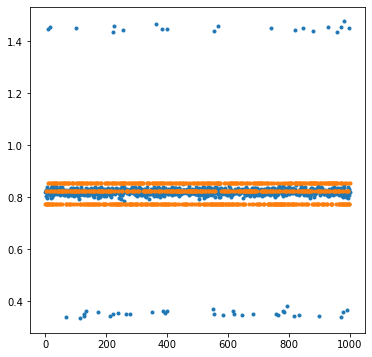

In [63]:
plt.plot(y, '.')
plt.plot(xi[zi], '.')

for k in jnp.arange(K):
    print(jnp.sum(zi==k))

In [64]:
logPiZ0 = logPi(xi, zi, y, sigma, alpha)
logPiZ1 = logPi(xi, zi.at[18].set(2), y, sigma, alpha)

jnp.exp(logPiZ1-logPiZ0)

DeviceArray(0.9694699, dtype=float32)

In [65]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

-12.429692
-1402.4031


In [66]:
z1 = z.at[0].set(1)
logPiZ0 = logPi(x, z, y, sigma, alpha)
logPiZ1 = logPi(x, z1, y, sigma, alpha)
r = jnp.exp(logPiZ1 - logPiZ0)
r

DeviceArray(1., dtype=float32)

335
329
336


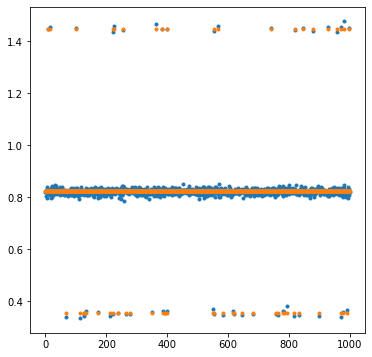

In [67]:
plt.plot(y, '.')
plt.plot(x[z], '.')

for k in jnp.arange(K):
    print(jnp.sum(zi==k))

In [68]:
print(pi)
print(x)
print(xi)

[0.02563246 0.9466571  0.0277105 ]
[1.4466679  0.82188    0.35398227]
[0.7726786  0.8537421  0.82399964]


In [ ]:
# Loss functions roughly equivalent with the the estimation problem to see what's going on
def loss_fun(x, z, y):
    return (x[z] - y)**2 * pi[z]

def loss_fun_vmap(x,z,y):
    n_k = calc_nk_jit(z)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))
    print(f"logPZalpha = {-logPZalpha}")
    return jnp.sum(jax.vmap(loss_fun, in_axes = (None, 0, 0))(x,z,y)) + jnp.sum(x**2) - logPZalpha

In [ ]:
n_k = calc_nk_jit(z)
logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

In [ ]:
jnp.sum(gammaln(n_k+alpha))

In [ ]:
gammaln(jnp.sum(n_k) + jnp.sum(alpha))

In [ ]:
alpha.shape

In [ ]:
print(loss_fun_vmap(x, jnp.array(np.random.randint(0, K, (N,))), y))
print(loss_fun_vmap(xi, zi, y))
print(loss_fun_vmap(x, z, y))

In [ ]:
alpha

### Some functions used for debugging - ignore

In [ ]:
# Quick test of a proposal function
key, subkey = random.split(key)
idx = 1
z1, rz, _, _ = proposal_z_idx(subkey, z, -1, x, y, sigma, alpha, K, idx)
print(z1[idx])
print(rz)

In [ ]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

In [ ]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   

print(probs_d)
#print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [ ]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [ ]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

In [ ]:
plt.imshow((myf_xy)); plt.colorbar()

In [ ]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

In [ ]:
myf(x[0],x[1])

In [ ]:
jnp.max(myf_xy)